In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from skimage.transform import resize

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import os
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/data23'


audio_urls = []
labels = []

In [ ]:
for label in ['real', 'fake']:
    folder_path = os.path.join(data_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            audio_urls.append(file_path)
            labels.append(label)

In [ ]:
print("Top 5 audio file paths:")
print(audio_urls[:5])

print("\nTop 5 labels:")
print(labels[:5])


Top 5 audio file paths:
['/content/drive/MyDrive/data23/real/file1071.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav', '/content/drive/MyDrive/data23/real/file1102.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav', '/content/drive/MyDrive/data23/real/file1036.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav', '/content/drive/MyDrive/data23/real/file1029.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav', '/content/drive/MyDrive/data23/real/file1100.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav']

Top 5 labels:
['real', 'real', 'real', 'real', 'real']


In [ ]:
df = pd.DataFrame({
    'url': audio_urls,
    'label': labels
})


print(df.head())

                                                 url label
0  /content/drive/MyDrive/data23/real/file1071.wa...  real
1  /content/drive/MyDrive/data23/real/file1102.wa...  real
2  /content/drive/MyDrive/data23/real/file1036.wa...  real
3  /content/drive/MyDrive/data23/real/file1029.wa...  real
4  /content/drive/MyDrive/data23/real/file1100.wa...  real


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)


In [ ]:
print(len(df))

820


In [ ]:
print("\nUnique labels in the dataset:")
print(df['label'].unique())


Unique labels in the dataset:
['fake' 'real']


In [ ]:
print(df.iloc[0])

print("URL:", df.iloc[0]['url'])
print("Label:", df.iloc[0]['label'])

print("Data Shape:",df.shape)
print("Class Distribution:",df["label"].value_counts())

url      /content/drive/MyDrive/data23/fake/file833.mp3...
label                                                 fake
Name: 0, dtype: object
URL: /content/drive/MyDrive/data23/fake/file833.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Label: fake
Data Shape: (820, 2)
Class Distribution: label
real    411
fake    409
Name: count, dtype: int64


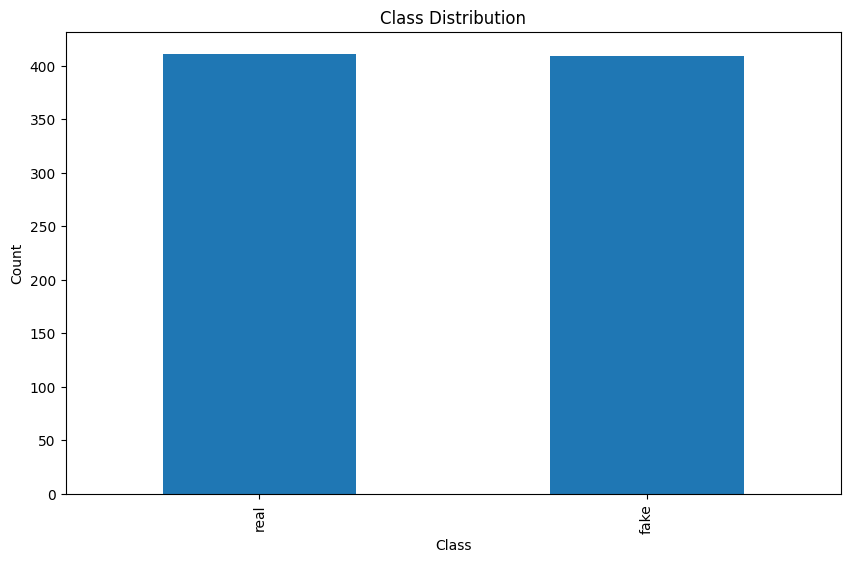

In [ ]:
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
df.head()

,url,label
0,/content/drive/MyDrive/data23/fake/file833.mp3...,fake
1,/content/drive/MyDrive/data23/real/file1751.wa...,real
2,/content/drive/MyDrive/data23/fake/file1889.mp...,fake
3,/content/drive/MyDrive/data23/fake/file1468.mp...,fake
4,/content/drive/MyDrive/data23/real/file1508.wa...,real


In [ ]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df['label'])


In [ ]:
df.head()

,url,label
0,/content/drive/MyDrive/data23/fake/file833.mp3...,0
1,/content/drive/MyDrive/data23/real/file1751.wa...,1
2,/content/drive/MyDrive/data23/fake/file1889.mp...,0
3,/content/drive/MyDrive/data23/fake/file1468.mp...,0
4,/content/drive/MyDrive/data23/real/file1508.wa...,1


In [ ]:
train = df.sample(frac=0.7, random_state=7)


In [ ]:
test = df.drop(train.index)      # Remaining 30% after removing training data
val = test.sample(frac=0.5, random_state=7)  # 50% of remaining becomes validation
test = test.drop(val.index)      # Final 50% becomes test


In [ ]:
len(train)

574

In [ ]:
train['label'].unique()

array([1, 0])

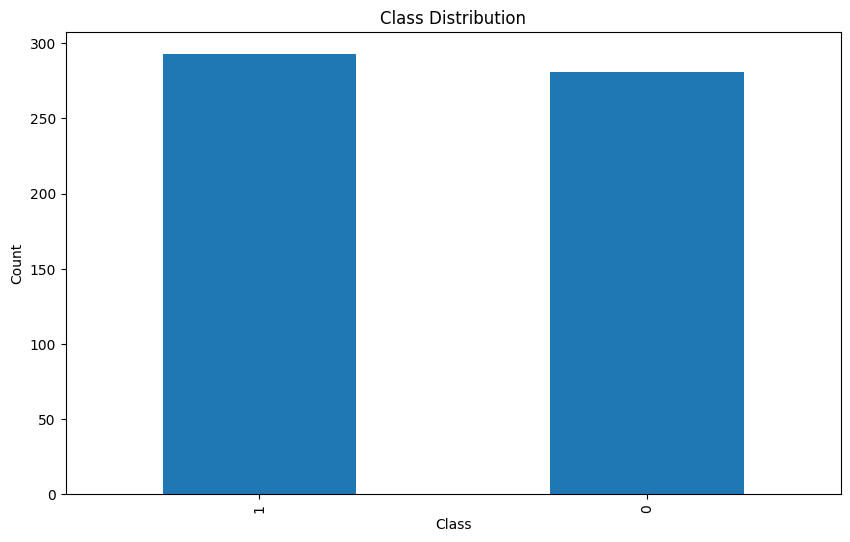

In [ ]:
plt.figure(figsize=(10, 6))
train['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
print("Train Shape:",train.shape)
print("Test Shape:",test.shape)
print("Val Shape:",val.shape)

Train Shape: (574, 2)
Test Shape: (123, 2)
Val Shape: (123, 2)


In [ ]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.labels=torch.Tensor(list(dataframe["label"])).type(torch.LongTensor).to(device)
        self.audios=[torch.tensor(self.get_spectrogram(url)) for url in dataframe['url']] # Changed this line
    def __len__(self): # Corrected indentation
        return len(self.dataframe)
    def __getitem__(self, idx): # Corrected indentation
        img_path=self.dataframe.iloc[idx,0]
        label=torch.Tensor(self.labels[idx]).to(device)
        audio = self.audios[idx].unsqueeze(0).to(device)
        return audio, label
    def get_spectrogram(self,url):
        sr=22050
        duration=10
        img_height=224
        img_width=224
        signal,sr=librosa.load(url,sr=sr,duration=duration)
        spec=librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=2048,hop_length=512,n_mels=128)
        spec_db=librosa.power_to_db(spec,ref=np.max)
        spec_resized=librosa.util.fix_length(spec_db,size=(duration*sr)//512+1)
        spec_resized=resize(spec_resized,(img_height,img_width),anti_aliasing=True)
        return spec_resized

In [ ]:
train_dataset=CustomAudioDataset(dataframe=train)
test_dataset=CustomAudioDataset(dataframe=test)
val_dataset=CustomAudioDataset(dataframe=val)

In [ ]:
class Net(nn.Module):
    def __init__(self, output_dim):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64 * 28 * 28, 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, output_dim)  # <--- Accept dynamic output_dim
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


In [ ]:
# ---- Hyperparameter Tuning ----
import itertools

learning_rates = [1e-3, 1e-4]
batch_sizes = [16, 32]
epoch_options = [10, 25]

In [ ]:
best_val_acc = 0
best_hyperparams = {}

In [ ]:
for lr, batch_size, epochs in itertools.product(learning_rates, batch_sizes, epoch_options):
    print(f"\n🔍 Trying LR={lr}, Batch Size={batch_size}, Epochs={epochs}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = Net(output_dim=len(df["label"].unique())).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, axis=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = (correct / total) * 100
    print(f"✅ Validation Accuracy = {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_hyperparams = {'learning_rate': lr, 'batch_size': batch_size, 'epochs': epochs}


🔍 Trying LR=0.001, Batch Size=16, Epochs=10
✅ Validation Accuracy = 49.59%

🔍 Trying LR=0.001, Batch Size=16, Epochs=25
✅ Validation Accuracy = 61.79%

🔍 Trying LR=0.001, Batch Size=32, Epochs=10
✅ Validation Accuracy = 54.47%

🔍 Trying LR=0.001, Batch Size=32, Epochs=25
✅ Validation Accuracy = 69.92%

🔍 Trying LR=0.0001, Batch Size=16, Epochs=10
✅ Validation Accuracy = 86.99%

🔍 Trying LR=0.0001, Batch Size=16, Epochs=25


In [ ]:
print("\n🏆 Best Hyperparameters Found:")
print(best_hyperparams)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

In [ ]:
# 1. Define the model
model = Net(output_dim=len(df["label"].unique())).to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=50176, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# 2. Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

In [ ]:
# # 3. Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# 4. For plotting
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

In [ ]:
# 5. Train the model
EPOCHS = 30

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        total_acc_train += (torch.argmax(outputs, axis=1) == labels).sum().item()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            total_loss_val += val_loss.item()
            total_acc_val += (torch.argmax(outputs, axis=1) == labels).sum().item()

    total_loss_train_plot.append(round(total_loss_train / len(train_loader), 4))
    total_loss_validation_plot.append(round(total_loss_val / len(val_loader), 4))
    total_acc_train_plot.append(round(total_acc_train / len(train_dataset) * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val / len(val_dataset) * 100, 4))

    print(f"""
    Epoch {epoch+1}/{EPOCHS}
    Train Loss: {round(total_loss_train/len(train_loader), 4)}
    Train Accuracy: {round((total_acc_train/len(train_dataset)) * 100, 2)}%
    Validation Loss: {round(total_loss_val/len(val_loader), 4)}
    Validation Accuracy: {round((total_acc_val/len(val_dataset)) * 100, 2)}%
    """)
    print("=" * 50)


    Epoch 1/30
    Train Loss: 8.9234
    Train Accuracy: 48.43%
    Validation Loss: 4.3509
    Validation Accuracy: 45.53%
    

    Epoch 2/30
    Train Loss: 3.0788
    Train Accuracy: 50.0%
    Validation Loss: 0.6923
    Validation Accuracy: 54.47%
    

    Epoch 3/30
    Train Loss: 1.0562
    Train Accuracy: 51.05%
    Validation Loss: 0.6624
    Validation Accuracy: 59.35%
    

    Epoch 4/30
    Train Loss: 0.721
    Train Accuracy: 57.84%
    Validation Loss: 0.6321
    Validation Accuracy: 66.67%
    

    Epoch 5/30
    Train Loss: 0.6462
    Train Accuracy: 61.85%
    Validation Loss: 0.6062
    Validation Accuracy: 61.79%
    

    Epoch 6/30
    Train Loss: 0.6762
    Train Accuracy: 59.58%
    Validation Loss: 0.6312
    Validation Accuracy: 56.91%
    

    Epoch 7/30
    Train Loss: 0.6274
    Train Accuracy: 63.94%
    Validation Loss: 0.5843
    Validation Accuracy: 69.11%
    

    Epoch 8/30
    Train Loss: 0.5821
    Train Accuracy: 66.55%
    Validation Loss

In [ ]:
# 6. Evaluate on the test set
model.eval()
total_acc_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predicted = torch.argmax(outputs, axis=1)
        total_acc_test += (predicted == labels).sum().item()

test_accuracy = round((total_acc_test / len(test_dataset)) * 100, 2)
print(f"✅ Test Accuracy = {test_accuracy}%")


✅ Test Accuracy = 83.74%


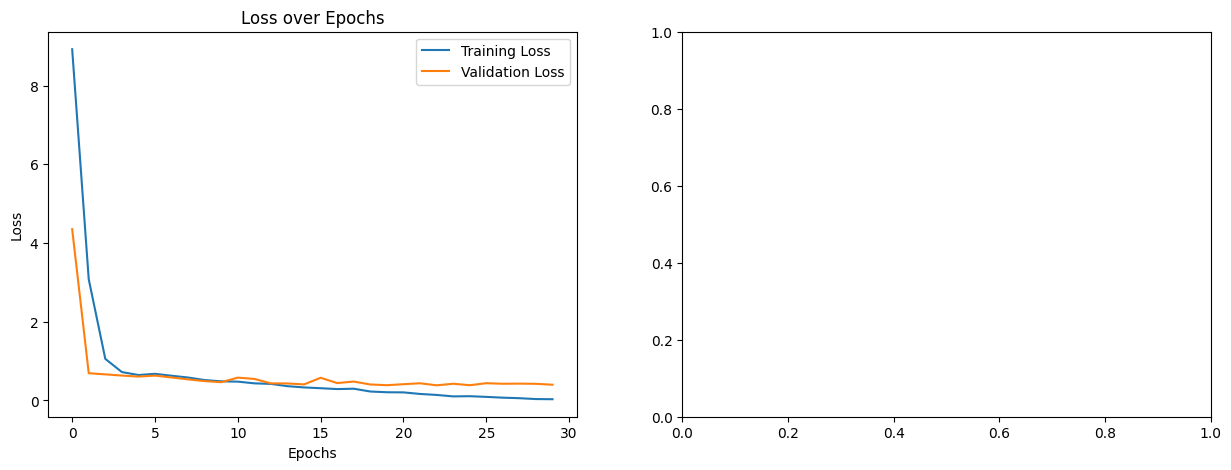

In [ ]:
# 7. Plot the loss and accuracy curves
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()


In [ ]:
# Accuracy plot
axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "audio_classification_model.pth")
print("✅ Model saved as audio_classification_model.pth")


✅ Model saved as audio_classification_model.pth


In [ ]:
# Define the same model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64 * 28 * 28, 4096)  # match training input shape
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, 2)  # 2 classes: real or fake
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.dropout(x)
        x = self.output(x)
        return x

In [ ]:
# Load the trained model
model = Net().to(device)
model.load_state_dict(torch.load("audio_classification_model.pth", map_location=device))
model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=50176, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Function to generate spectrogram
def get_mel_spectrogram(wav_path):
    sr = 22050
    duration = 10
    img_height = 224
    img_width = 224
    signal, sr = librosa.load(wav_path, sr=sr, duration=duration)
    spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    spec_resized = librosa.util.fix_length(spec_db, size=(duration * sr)//512 + 1)
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
    return spec_resized

In [ ]:
# Function to predict from a .wav file
def predict_audio(wav_path):
    spectrogram = get_mel_spectrogram(wav_path)
    spectrogram_tensor = torch.tensor(spectrogram).unsqueeze(0).unsqueeze(0).float().to(device)  # (batch, channel, H, W)

    with torch.no_grad():
        output = model(spectrogram_tensor)
        pred = torch.argmax(output, axis=1).item()

    label_map = {0: 'Real', 1: 'Fake'}
    predicted_label = label_map[pred]

    # Show the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Predicted: {predicted_label}")
    plt.tight_layout()
    plt.show()

    print(f"🎯 Predicted Label: {predicted_label}")

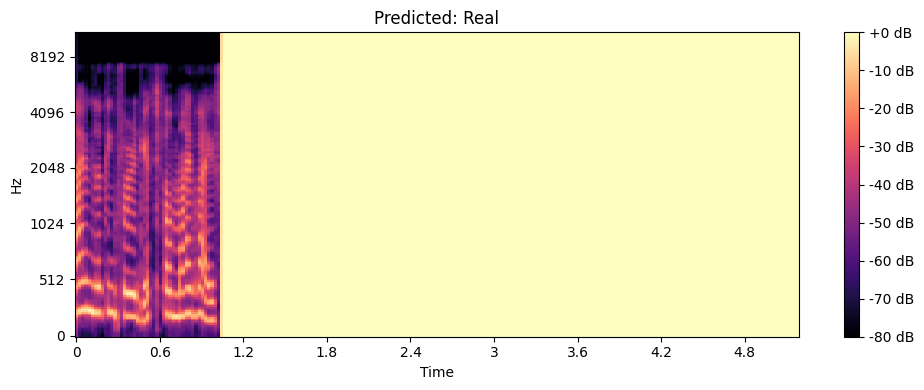

🎯 Predicted Label: Real


In [ ]:
# Example Usage
wav_path = "/content/file367.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav"  # Replace with your .wav file path
predict_audio(wav_path)